In [2]:
from sklearn.metrics import accuracy_score, zero_one_loss, classification_report, confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.anova import anova_lm
from sklearn.svm import SVC
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from scipy import stats
import numpy as np 
import pandas as pd 
import seaborn as sns 

In [3]:
liver_train = pd.read_csv("indian_liver_patient_train.csv")
liver_test = pd.read_csv("indian_liver_patient_test.csv")

liver_df = pd.concat([liver_train, liver_train])

Let's take a look at missing values and see if they need preprocessing.

In [46]:
liver_df.isna().sum()

ID                            0
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    6
Category                      0
dtype: int64

As well as the relative distribution of values

In [47]:
liver_df.describe()

,ID,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Category
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,912.000000,918.000000
mean,286.801743,44.819172,3.191068,1.405447,289.786492,80.376906,108.810458,6.479739,3.153595,0.956294,1.294118
std,171.054469,16.105296,6.218906,2.692271,244.689450,189.079431,306.289984,1.087193,0.787943,0.324010,0.455893
min,0.000000,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,134.250000,33.000000,0.800000,0.200000,176.000000,23.250000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,287.000000,45.000000,1.000000,0.300000,206.000000,35.000000,42.000000,6.600000,3.100000,0.960000,1.000000
75%,433.750000,57.000000,2.475000,1.200000,298.000000,60.000000,86.750000,7.200000,3.800000,1.100000,2.000000
max,582.000000,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


C:\Users\Makarand\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Albumin_and_Globulin_Ratio', ylabel='Density'>

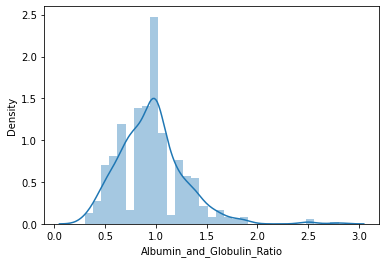

In [60]:
sns.distplot(liver_df["Albumin_and_Globulin_Ratio"])

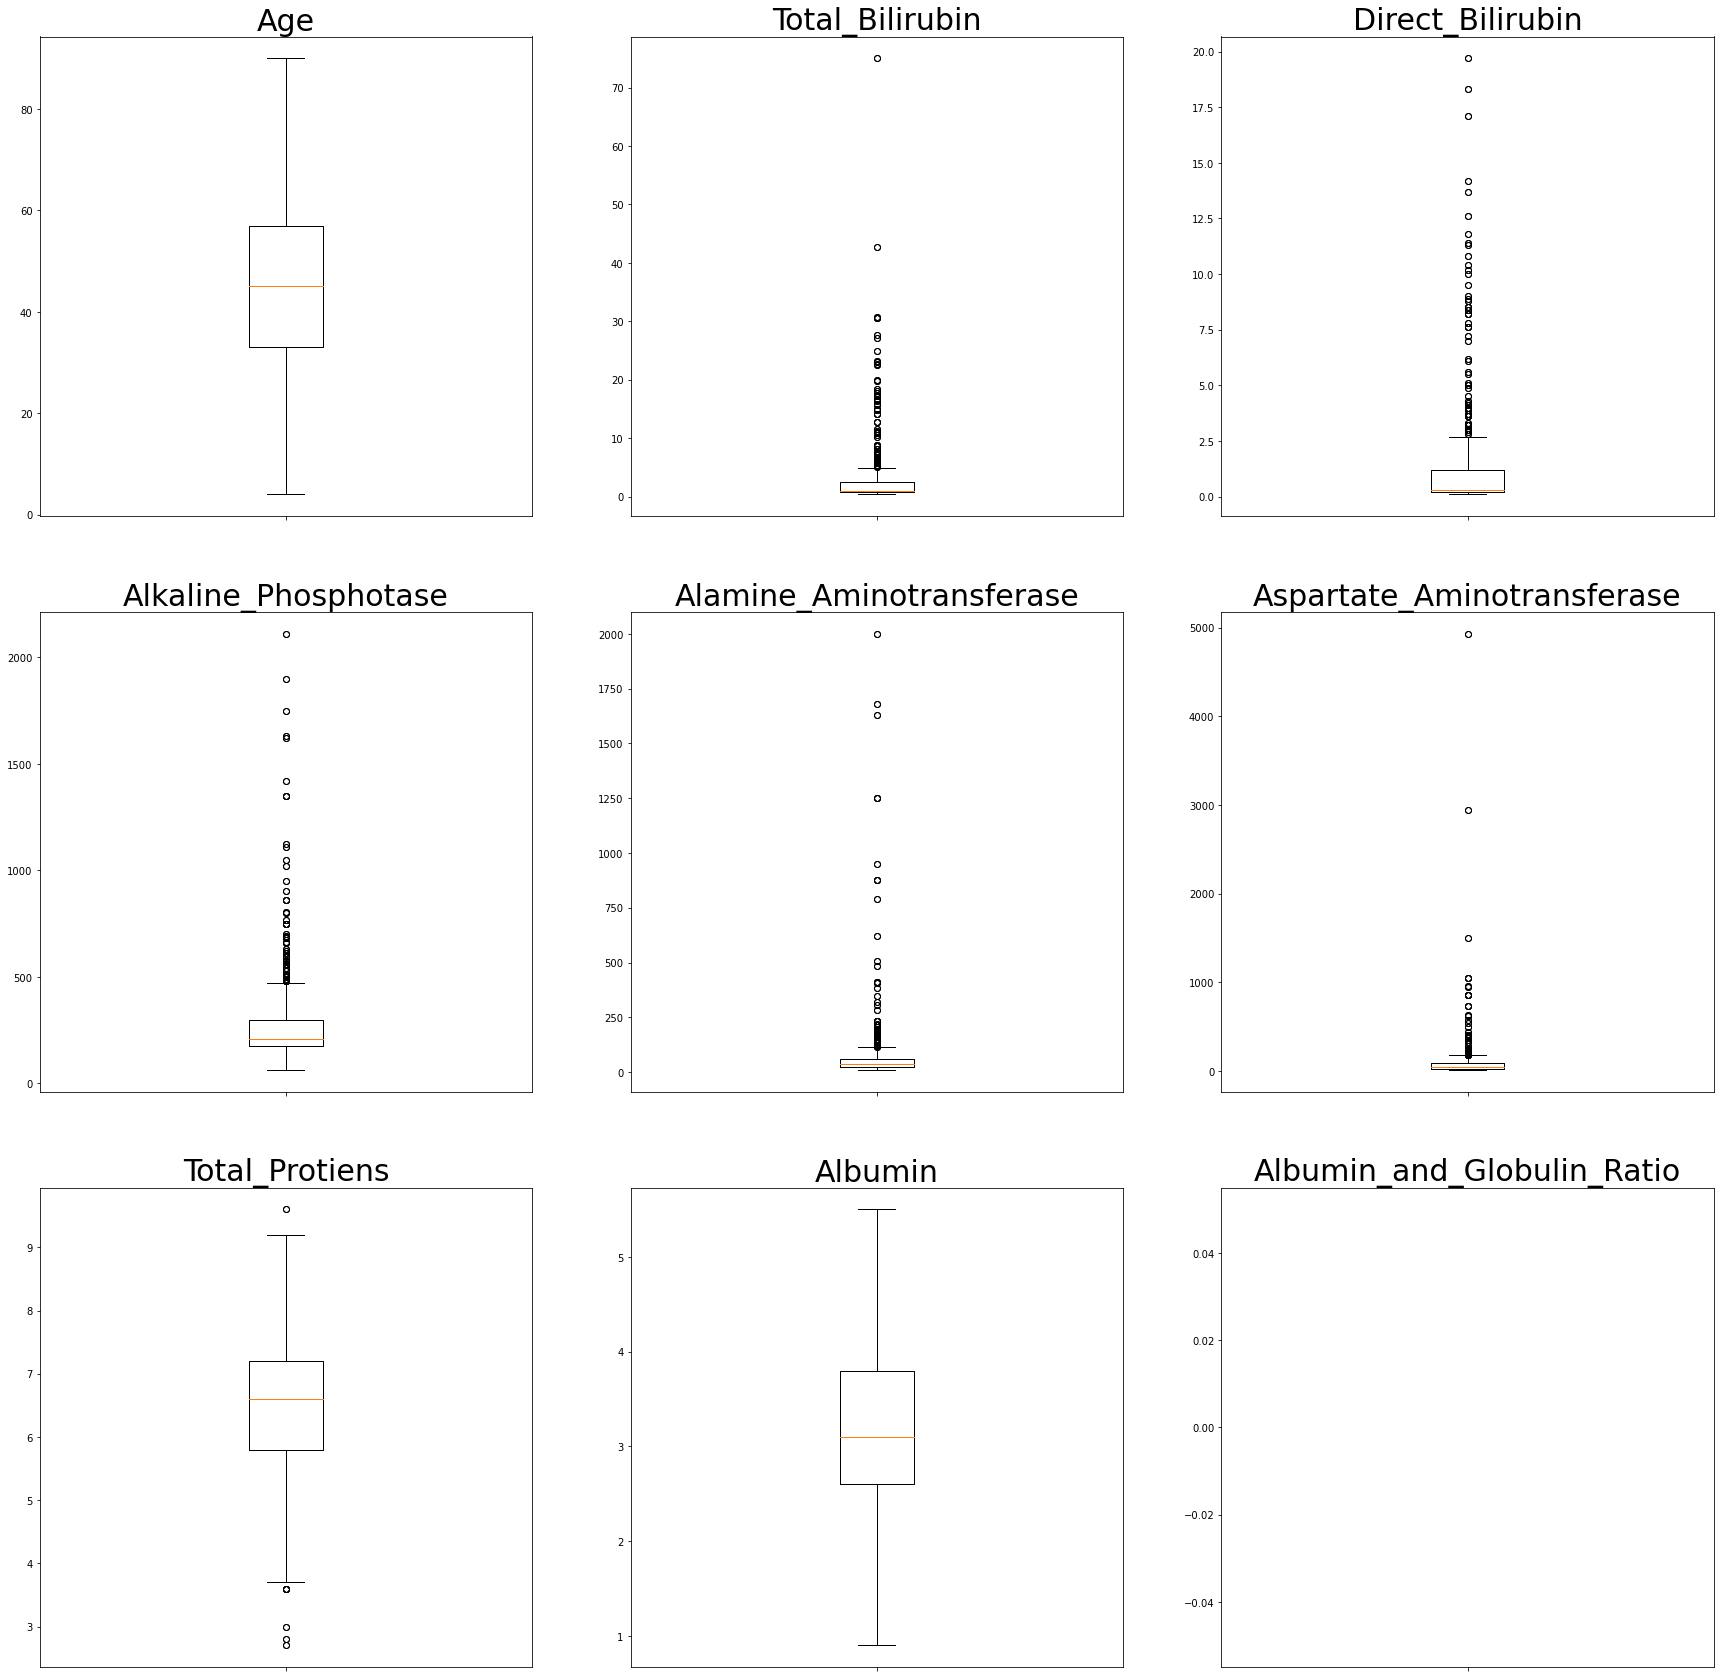

In [55]:
fig, ax = plt.subplots(3,3, figsize = (30, 30))
i=0
for name, val in liver_df.items():
    if name not in ["Gender","ID","Category"]:
        ax[i//3][i%3].boxplot(val)
        ax[i//3][i%3].set_title(name, fontsize=30)
        ax[i//3][i%3].set_xticklabels(ax[i//3][i%3].get_xticklabels(), fontsize="x-large")
        i+=1
plt.show()

<BarContainer object of 2 artists>

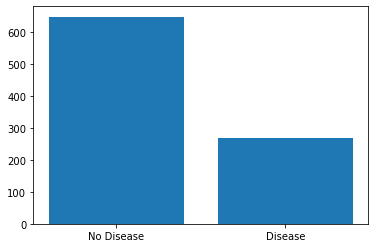

In [67]:
plt.bar(["No Disease","Disease"],liver_df["Category"].value_counts())

Here, we'll scale the values appropriately.

In [4]:
scaler = StandardScaler()
continuous_vars = ['Age',
 'Total_Bilirubin',
 'Direct_Bilirubin',
 'Alkaline_Phosphotase',
 'Alamine_Aminotransferase',
 'Aspartate_Aminotransferase',
 'Total_Protiens',
 'Albumin',
 'Albumin_and_Globulin_Ratio']

liver_df[['Age','Total_Bilirubin','Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase','Aspartate_Aminotransferase','Total_Protiens','Albumin','Albumin_and_Globulin_Ratio']] = scaler.fit_transform(liver_df[['Age','Total_Bilirubin','Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase','Aspartate_Aminotransferase','Total_Protiens','Albumin','Albumin_and_Globulin_Ratio']])


We're doing to do some preprocessing of the variables to ensure that the gender and outcome variables are converted to binary variables. 

In [5]:
# preprocessing
liver_df.dropna(inplace=True)
liver_df["Gender"] = liver_df["Gender"] == "Male"
liver_df["Gender"] = liver_df["Gender"].apply(lambda x: int(x))
liver_df["Category"] = liver_df["Category"] - 1
liver_df.head()

,ID,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Category
0,0,1.253738,0,-0.400782,-0.485151,-0.420298,-0.340661,-0.296647,0.294737,0.185908,-0.173836,0
1,1,1.067363,1,1.240272,1.521684,1.673291,-0.086661,-0.028781,0.938948,0.058926,-0.667919,0
2,2,1.067363,1,0.661076,1.001393,0.818681,-0.107828,-0.133314,0.478797,0.185908,-0.204716,0
3,3,0.818862,1,-0.352516,-0.373660,-0.440743,-0.351244,-0.290114,0.294737,0.312890,0.134965,0
4,5,0.073359,1,-0.223806,-0.262169,-0.334428,-0.324786,-0.309713,1.030978,1.582709,1.061369,0


Now that we have our data in the form that we want it, let's do feature selection using a logistic regression model.

In [9]:
# Let's do feature selection using a logistic regression model

feature_matrix = sm.add_constant(liver_df[['Age',"Gender","Total_Bilirubin",'Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase','Total_Protiens','Albumin','Albumin_and_Globulin_Ratio']], prepend=False)
y = liver_df["Category"].to_numpy()

# Fit and summarize OLS model
full_model = sm.Logit(y, feature_matrix)
res = full_model.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.495930
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  912
Model:                          Logit   Df Residuals:                      902
Method:                           MLE   Df Model:                            9
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.1784
Time:                        23:32:11   Log-Likelihood:                -452.29
converged:                       True   LL-Null:                       -550.52
Covariance Type:            nonrobust   LLR p-value:                 1.830e-37
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                           -0.3189      0.081     -3.919      0.000      

On first look, it seems we can possibly drop Gender, Total Birilubin, and the A to G ratio. Let's use nested model testing to check whether we can drop these variables.

In [10]:
# Creating the models for nested model testing

no_gender_feature_matrix = sm.add_constant(liver_df[['Age',"Total_Bilirubin",'Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase','Total_Protiens','Albumin','Albumin_and_Globulin_Ratio']], prepend=False)
no_gender_bilirubin_feature_matrix = sm.add_constant(liver_df[['Age','Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase','Total_Protiens','Albumin','Albumin_and_Globulin_Ratio']], prepend=False)
no_gender_bilirubin_albumin_feature_matrix = sm.add_constant(liver_df[['Age','Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase','Total_Protiens','Albumin']], prepend=False)

no_gender_model = sm.Logit(y, no_gender_feature_matrix)
no_gender_res = no_gender_model.fit()
print(no_gender_res.summary())

no_gender_bilirubin_model = sm.Logit(y, no_gender_bilirubin_feature_matrix)
no_gender_bilirubin_res = no_gender_bilirubin_model.fit()
print(no_gender_bilirubin_res.summary())

no_gender_bilirubin_albumin_model = sm.Logit(y, no_gender_bilirubin_albumin_feature_matrix)
no_gender_bilirubin_albumin_res = no_gender_bilirubin_albumin_model.fit()
print(no_gender_bilirubin_albumin_res.summary())


Optimization terminated successfully.
         Current function value: 0.495965
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  912
Model:                          Logit   Df Residuals:                      903
Method:                           MLE   Df Model:                            8
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.1784
Time:                        23:32:15   Log-Likelihood:                -452.32
converged:                       True   LL-Null:                       -550.52
Covariance Type:            nonrobust   LLR p-value:                 3.673e-38
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                           -0.3181      0.081     -3.913      0.000      

In [68]:
def lrtest(llmax, llmin):
    lr = 2 * (llmax - llmin)
    p = stats.chi2.sf(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

model1_nest = lrtest(res.llf, no_gender_res.llf)
model2_nest = lrtest(no_gender_res.llf, no_gender_bilirubin_res.llf)
model3_nest = lrtest(no_gender_bilirubin_res.llf, no_gender_bilirubin_albumin_res.llf)

print(f"Full Model versus Gender-less: Likelihood Ratio Test\n Chi-Sq Test Statistic: {model1_nest[0]}, p-value: {model1_nest[1]}")
print()
print(f"Gender-less versus Gender & Total Birilubin-less: Likelihood Ratio Test\n Chi-Sq Test Statistic: {model2_nest[0]}, p-value: {model2_nest[1]}")
print()
print(f"Gender & Total Birilubin-less versus Gender & Total Birilubin & Albumin and Globulin Ratio: Likelihood Ratio Test\n Chi-Sq Test Statistic: {model3_nest[0]}, p-value: {model3_nest[1]}")

Full Model versus Gender-less: Likelihood Ratio Test
 Chi-Sq Test Statistic: 0.06416915213037555, p-value: 0.8000237946811248

Gender-less versus Gender & Total Birilubin-less: Likelihood Ratio Test
 Chi-Sq Test Statistic: 0.009389962940758778, p-value: 0.9228043625527276

Gender & Total Birilubin-less versus Gender & Total Birilubin & Albumin and Globulin Ratio: Likelihood Ratio Test
 Chi-Sq Test Statistic: 3.497018821109691, p-value: 0.061479406186215016


So based on the results above, it seems that it's quite safe to drop Gender and Total Birilubin. 

While it's true that the Albumin to Globulin Ratio with and without nested model test 
doesn't reject the null hypothesis that the likelihoods are significantly different at 95% confidence,
at 90% confidence it does, so as a precaution we'll leave that variable in our analysis.

Let's split the data into our training and test splits.

In [6]:
X = liver_df.drop(axis = 1, columns = ["ID","Category", "Gender","Total_Bilirubin"])
y = liver_df["Category"]
X_train, X_test, y_train, y_test_data = train_test_split(X, y, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test_data.shape)

(638, 8) (274, 8) (638,) (274,)


In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [14]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      1.00      1.00       188

    accuracy                           1.00       638
   macro avg       1.00      1.00      1.00       638
weighted avg       1.00      1.00      1.00       638



In [15]:
print(classification_report(y_test_data, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       196
           1       0.85      0.72      0.78        78

    accuracy                           0.88       274
   macro avg       0.87      0.83      0.85       274
weighted avg       0.88      0.88      0.88       274



Let's perform a grid search on each of our models in question with each of their parameters to determine the best versions of these models.

In [7]:
param_grid = {"max_depth":range(1,18), 
"max_features":[0.2, 0.4, 0.6, 0.8]}
svm_param_grid = {"gamma" : ['scale', 'auto'], "C":[i for i in np.arange(0.1, 1, 0.1)]}
knn_param_grid = {"n_neighbors":[k for k in range(1,25)],"weights":["uniform", "distance"]}
gbm_grid = dict()
gbm_grid['n_estimators'] = [10, 50, 100, 500]
gbm_grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
gbm_grid['subsample'] = [0.5, 0.7, 1.0]
gbm_grid['max_depth'] = [3, 7, 9]

# Initialize Estimators
clf = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC()
knn = KNeighborsClassifier()
gbm = GradientBoostingClassifier()

# Initialize Grid Searchers
gridsearch_clf = GridSearchCV(clf, param_grid, cv = 8, n_jobs = -1)
gridsearch_rf = GridSearchCV(rf, param_grid, cv = 8, n_jobs = -1)
gridsearch_svc = GridSearchCV(svc, svm_param_grid, cv = 8, n_jobs = -1)
gridsearch_knn = GridSearchCV(knn, knn_param_grid, cv = 8, n_jobs = -1)
gridsearch_gbm = GridSearchCV(gbm, gbm_grid, cv = 8, n_jobs = -1)

# Fit the models
gridsearch_clf.fit(X_train, y_train)
gridsearch_rf.fit(X_train, y_train)
gridsearch_svc.fit(X_train, y_train)
gridsearch_knn.fit(X_train, y_train)
gridsearch_gbm.fit(X_train, y_train)

GridSearchCV(cv=8, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'max_depth': [3, 7, 9],
                         'n_estimators': [10, 50, 100, 500],
                         'subsample': [0.5, 0.7, 1.0]})

In [17]:
gridsearch_clf.best_params_

{'max_depth': 16, 'max_features': 0.8}

In [18]:
gridsearch_rf.best_params_

{'max_depth': 17, 'max_features': 0.2}

In [19]:
gridsearch_svc.best_params_

{'C': 0.9, 'gamma': 'scale'}

In [20]:
gridsearch_knn.best_params_

{'n_neighbors': 19, 'weights': 'distance'}

In [25]:
gridsearch_gbm.best_params_

{'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Now we select the best estimators and predict the results on the test sets.

In [28]:
clf_best = gridsearch_clf.best_estimator_
rf_best = gridsearch_rf.best_estimator_
svc_best = gridsearch_svc.best_estimator_
knn_best = gridsearch_knn.best_estimator_
gbm_best = gridsearch_gbm.best_estimator_

clf_y_test_pred = clf_best.predict(X_test)
rf_y_test_pred = rf_best.predict(X_test)
svc_y_test_pred = svc_best.predict(X_test)
knn_y_test_pred = knn_best.predict(X_test)
gbm_y_test_pred = gbm_best.predict(X_test)

In [35]:
print("Decision Tree Classification Report")
print(classification_report(y_test_data,clf_y_test_pred))

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       196
           1       0.81      0.74      0.77        78

    accuracy                           0.88       274
   macro avg       0.85      0.84      0.84       274
weighted avg       0.87      0.88      0.87       274



In [36]:
print("Random Forest Classification Report")
print(classification_report(y_test_data,rf_y_test_pred))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       196
           1       0.90      0.72      0.80        78

    accuracy                           0.90       274
   macro avg       0.90      0.84      0.87       274
weighted avg       0.90      0.90      0.89       274



In [37]:
print("Support Vector Machine Classification Report")
print(classification_report(y_test_data,svc_y_test_pred))

Support Vector Machine Classification Report
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       196
           1       0.50      0.04      0.07        78

    accuracy                           0.72       274
   macro avg       0.61      0.51      0.45       274
weighted avg       0.66      0.72      0.62       274



In [38]:
print("K-Nearest Neighbors Classification Report")
print(classification_report(y_test_data,knn_y_test_pred))

K-Nearest Neighbors Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       196
           1       0.78      0.79      0.78        78

    accuracy                           0.88       274
   macro avg       0.85      0.85      0.85       274
weighted avg       0.88      0.88      0.88       274



In [39]:
print("Gradient Boosting Machine Classification Report")
print(classification_report(y_test_data,gbm_y_test_pred))

Gradient Boosting Machine Classification Report
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       196
           1       0.82      0.72      0.77        78

    accuracy                           0.88       274
   macro avg       0.86      0.83      0.84       274
weighted avg       0.87      0.88      0.87       274

